In [9]:
#Ignoring TF warning messages
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

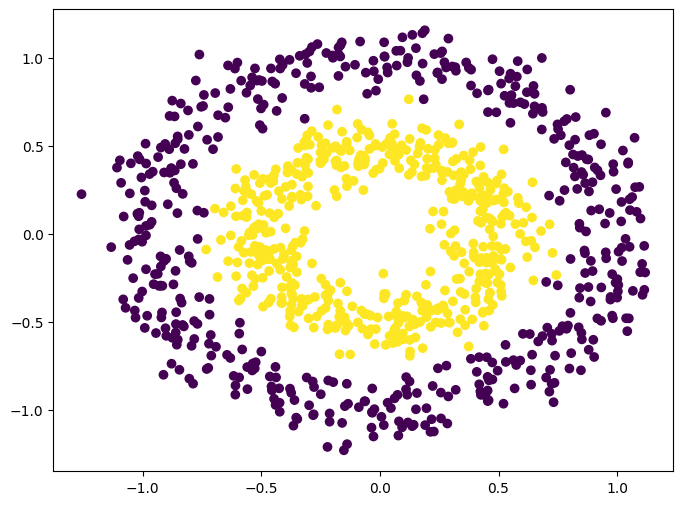

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score

tf.random.set_seed(42)
np.random.seed(42)

# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()



In [11]:
# Test performance with 3-layer binary classification network
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "relu"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 0s 4ms/step - loss: 0.2559 - acc: 0.9120
[0.2558740973472595, 0.9120000004768372]


In [12]:
# Test performance with 3-layer network with sigmoid activation
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 1s 5ms/step - loss: 0.6908 - acc: 0.5590
[0.69082111120224, 0.5590000152587891]


In [13]:
# Test performance with 5-layer network with sigmoid activation
model = Sequential([
    Input(shape=(2,)),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(5, "sigmoid"),
    Dense(1, "sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=32, epochs=100, verbose=0)
print(model.evaluate(X,y))



32/32 [==============================] - 0s 5ms/step - loss: 0.6925 - acc: 0.5000
[0.6924762725830078, 0.5]


In [14]:
# Illustrate weights across epochs
class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

def make_mlp(activation, initializer, name):
    "Create a model with specified activation and initalizer"
    model = Sequential([
        Input(shape=(2,), name=name+"0"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"1"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"2"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"3"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"4"),
        Dense(1, activation="sigmoid", kernel_initializer=initializer, name=name+"5")
    ])
    return model


In [15]:
def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean weight")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.show()

In [16]:
initializer = RandomNormal(mean=0, stddev=1)
batch_size = 32
n_epochs = 100

Before training: Accuracy 0.5


/home/yaduk/anaconda3/envs/deepl/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


After training: Accuracy 0.533
32/32 [==============================] - 0s 5ms/step - loss: 0.6895 - acc: 0.5330
[0.6894616484642029, 0.5329999923706055]


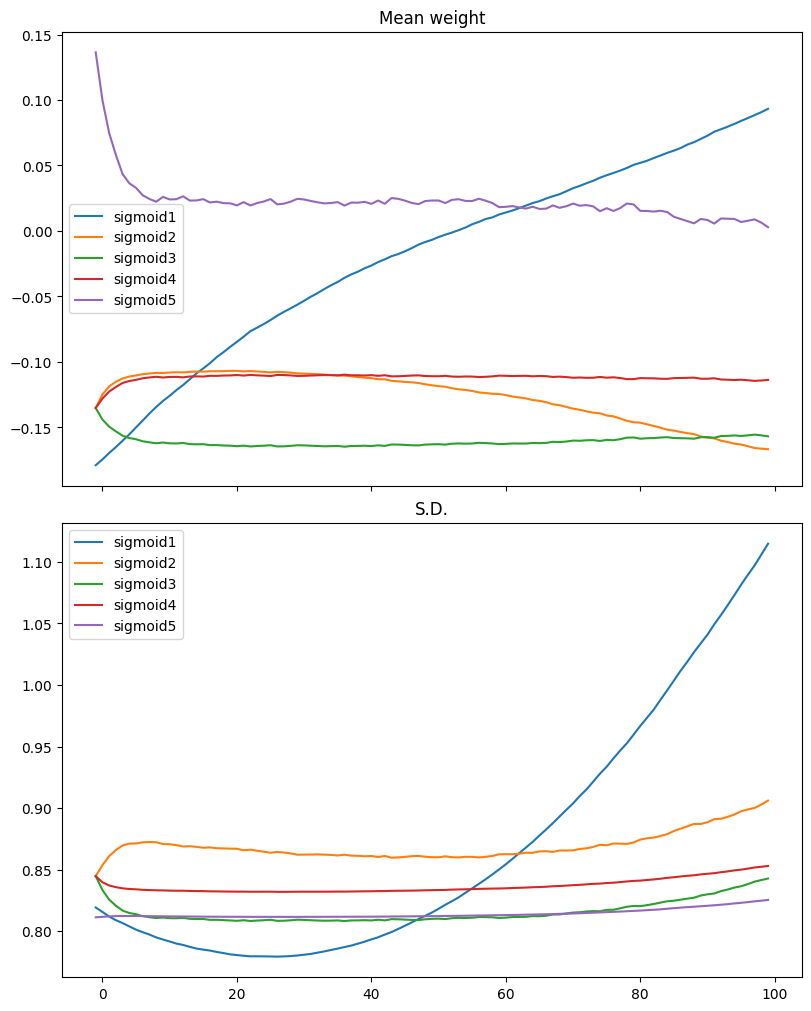

In [17]:
# Sigmoid activation
model = make_mlp("sigmoid", initializer, "sigmoid")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print("Before training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print("After training: Accuracy", accuracy_score(y, (model(X).numpy() > 0.5).astype(int)))
print(model.evaluate(X,y))
plotweight(capture_cb)